# LDAS Cloud Use Case

## Demonstrate differences in soil moisture between LDAS model output and CYGNSS satellite retrievals in the Earthdata Cloud

### Audience
Soil moisture researchers who want to see differences between model- and satellite-based products

### Goal
Compare soil moisture from LDAS (NLDAS, GLDAS models) and CYGNSS (satellite retrieval) in different regions of the world (Southern Great Plains, East Africa) using in-region Earthdata Cloud access.

### Assumptions
- A variable of interest is identified
- Data collections of interest are identified
- User has procured access to computing resources in the AWS us-west-2 region

### Preconditions
- User has access to computing resources in the AWS us-west-2 region
- LDAS and CYGNSS data collections are available in the Earthdata Cloud
- Identify area(s) of interest for area-averaging
    - Southern Great Plains: 100-95 W and 32-37 N
    - East Africa: 43-48 E and 5-10 N  

<p></p>

<div style="background:#fc9090;border:1px solid #cccccc;padding:5px 10px;"><big><b>Note:  </b>Because this notebook uses the S3 protocol, <em><strong>it will only run in an environment with <a href="https://disc.gsfc.nasa.gov/information/glossary?keywords=%22earthdata%20cloud%22&amp;title=AWS%20region">us-west-2 AWS access</a></strong></em>.</big></div>

## Prerequisites

This notebook was written using Python 3.8, and requires these libraries and files:
- xarray
- cartopy
- matplotlib
- S3FS
  - S3FS documentation: (https://s3fs.readthedocs.io/en/latest/install.html)
- netrc file with valid Earthdata Login credentials
- Approval to access the GES DISC archives with your Earthdata credentials (https://disc.gsfc.nasa.gov/earthdata-login)

## Import Libraries

In [1]:
from netrc import netrc
from subprocess import Popen
from platform import system
from getpass import getpass
import os
import requests
import xarray as xr
import s3fs
from scipy.interpolate import griddata
import numpy as np

## Credentials

Two credentials are required for in-cloud direct S3 access of Earthdata:
 - Earthdata Login username and password
 - Temporary S3 access credential for NASA DAAC archives

The S3 credential is generated by a lambda function that uses the Earthdata Login credentials provided in your <code>.netrc</code> file to create an access key ID, secret access key, and session token for accessing GES DISC S3 buckets. **This token will only last for one hour**, and if time expires, the kernel will need to be reset and the following cell run again. This notebook also accesses data archived by PO.DAAC. You will also need to generate S3 credentials for PO.DAAC.

### STOP: Do you have your Earthdata Login credentials stored in the root directory of this compute system?

If no, run the below cell to store your Earthdata username and password in a <code>.netrc</code> file.
    
If yes, proceed to the next cell.
    


In [2]:
## You may skip this cell if you have already stored your Earthdata Login credentials

urs = 'urs.earthdata.nasa.gov'    # Earthdata URL endpoint for authentication
prompts = ['Enter NASA Earthdata Login Username: ',
           'Enter NASA Earthdata Login Password: ']

netrc_name = ".netrc"

# Determine if netrc file exists, and if so, if it includes NASA Earthdata Login Credentials
try:
    netrcDir = os.path.expanduser(f"~/{netrc_name}")
    netrc(netrcDir).authenticators(urs)[0]

# Below, create a netrc file and prompt user for NASA Earthdata Login Username and Password
except FileNotFoundError:
    homeDir = os.path.expanduser("~")
    Popen('touch {0}{2} | echo machine {1} >> {0}{2}'.format(homeDir + os.sep, urs, netrc_name), shell=True)
    Popen('echo login {} >> {}{}'.format(getpass(prompt=prompts[0]), homeDir + os.sep, netrc_name), shell=True)
    Popen('echo \'password {} \'>> {}{}'.format(getpass(prompt=prompts[1]), homeDir + os.sep, netrc_name), shell=True)
    # Set restrictive permissions
    Popen('chmod 0600 {0}{1}'.format(homeDir + os.sep, netrc_name), shell=True)

In [3]:
gesdisc_s3 = "https://data.gesdisc.earthdata.nasa.gov/s3credentials"
podaac_s3 = "https://archive.podaac.earthdata.nasa.gov/s3credentials"

# Define a function for S3 access credentials
def begin_s3_direct_access(url: str=gesdisc_s3):
    response = requests.get(url).json()
    return s3fs.S3FileSystem(key=response['accessKeyId'],
                             secret=response['secretAccessKey'],
                             token=response['sessionToken'],
                             client_kwargs={'region_name':'us-west-2'})

## Find Data

Use the CMR API to search for the data collections of interest in the desired time range and create a list of S3 URLs that will be accessed. 

### Date Range

- 01 June 2018 - 10 October 2018

### Region

- Southern Great Plains (100-95 W and 32-37 N)

### Data Collections and Variables
| Longname    | Shortname | Variable | CMR Concept ID | Time Resolution | Spatial Resolution |
| ----------- | ----------- | ----------- | ----------- | ----------- | ----------- |
| [NLDAS Noah Land Surface Model L4 Hourly 0.125 x 0.125 degree V2.0](https://disc.gsfc.nasa.gov/datasets/NLDAS_NOAH0125_H_2.0/summary?keywords=NLDAS_NOAH0125_H) | NLDAS_NOAH0125_H | SoilM_0_10cm | C2069246977-GES_DISC | Hourly | 0.125 deg |
| [GLDAS Noah Land Surface Model L4 3 hourly 0.25 x 0.25 degree V2.1](https://disc.gsfc.nasa.gov/datasets/GLDAS_NOAH025_3H_2.1/summary?keywords=GLDAS_NOAH025_3H_2.1) | GLDAS_NOAH025_3H | SoilMoi0_10cm_inst | C1342986035-GES_DISC | 3-Hourly | 0.25 deg | 
| [UCAR-CU CYGNSS Level 3 Soil Moisture Version 1.0](https://podaac.jpl.nasa.gov/dataset/CYGNSS_L3_SOIL_MOISTURE_V1.0) | CYGNSS_L3_SOIL_MOISTURE_V1.0 | SM_daily | C2205122332-POCLOUD | Daily | ~0.37 deg lon. by ~0.30 deg lat. |



In [4]:
# Create a function for CMR catalog requests
def cmr_request(params):
    response = requests.get(url,
                        params=params,
                        headers={
                            'Accept': 'application/json',
                        }
                       )
    return response

In [5]:
url = 'https://cmr.earthdata.nasa.gov/search/granules'
start_time = '2018-06-01T00:00:00Z'
end_time = '2018-07-01T00:00:00Z'

### NLDAS hourly granules 

Use the table above to fill in the concept ID for the NLDAS data collection in the CMR API call. Create a list of S3 URLs based on the CMR response for your search. 

Estimate the number of granules you expect to find based on the time resolution and time range and adjust the page size accordingly.

In [6]:
nldas_concept_id = 'C2069246977-GES_DISC'
page_size = 24*30+1
response = cmr_request({
                        'concept_id': nldas_concept_id,
                        'temporal': start_time+','+end_time,
                        'page_size': page_size
                        })
nldas_granules = response.json()['feed']['entry']

nldas_s3_urls = []
for granule in nldas_granules:
    nldas_s3_urls.append(next((item['href'] for item in granule['links'] if item["href"].startswith("s3://")), None))

### GLDAS 3-hourly granules 

Use the table above to fill in the concept ID for the GLDAS data collection in the CMR API call. Create a list of S3 URLs based on the CMR response for your search. 

Estimate the number of granules you expect to find based on the time resolution and time range and adjust the page size accordingly.

In [7]:
gldas_concept_id = 'C1342986035-GES_DISC'
page_size = 8*30+1
response = cmr_request({
                        'concept_id': gldas_concept_id,
                        'temporal': start_time+','+end_time,
                        'page_size': page_size
                        })
gldas_granules = response.json()['feed']['entry']

gldas_s3_urls = []
for granule in gldas_granules:
    gldas_s3_urls.append(next((item['href'] for item in granule['links'] if item["href"].startswith("s3://")), None))

### CYGNSS daily granules 

Use the table above to fill in the concept ID for the CYGNSS data collection in the CMR API call. Create a list of S3 URLs based on the CMR response for your search. 

Estimate the number of granules you expect to find based on the time resolution and time range and adjust the page size accordingly.

In [8]:
cygnss_concept_id = 'C2205122332-POCLOUD'
page_size = 31
response = cmr_request({
                        'concept_id': cygnss_concept_id,
                        'temporal': start_time+','+end_time,
                        'page_size': page_size
                        })
cygnss_granules = response.json()['feed']['entry']

cygnss_s3_urls = []
for granule in cygnss_granules:
    cygnss_s3_urls.append(next((item['href'] for item in granule['links'] if item["href"].startswith("s3://") and item["href"].endswith(".nc")), None)) 

## Access Data

### Begin S3FS sessions

Begin your S3FS session that you set up earlier in the "Credentials" section.

Remember, these S3FS sessions are specific to the DAAC-owned S3 buckets, so we will create a session for each DAAC we are accessing data from.

In [9]:
fs_gesdisc = begin_s3_direct_access(gesdisc_s3)
fs_podaac = begin_s3_direct_access(podaac_s3)

# Check that the file system is intact as an S3FileSystem object, which means that token is valid
# Common causes of rejected S3 access tokens include incorrect passwords stored in the netrc file, or a non-existent netrc file
type(fs_gesdisc), type(fs_podaac)

(s3fs.core.S3FileSystem, s3fs.core.S3FileSystem)

### Open granules using xarray

We will use the xarray Python library to read and open the files we found using the CMR API and put into lists. 

In [11]:
%%time
nldas_ds = xr.open_mfdataset(
    paths=[fs_gesdisc.open(f) for f in nldas_s3_urls[0:24]],
    combine='by_coords',
    decode_cf=True,
)

CPU times: user 16.8 s, sys: 2.29 s, total: 19 s
Wall time: 42.5 s


In [12]:
%%time
gldas_ds = xr.open_mfdataset(
    paths=[fs_gesdisc.open(f) for f in gldas_s3_urls[0:8]],
    combine='by_coords',
    mask_and_scale=True,
    decode_cf=True,
    parallel=False,
)

CPU times: user 6.21 s, sys: 70.7 ms, total: 6.28 s
Wall time: 7.7 s


In [13]:
%time
cygnss_ds = xr.open_mfdataset(
    paths=[fs_podaac.open(f) for f in cygnss_s3_urls[0:1]],
    combine='by_coords',
    mask_and_scale=True,
    decode_cf=True,
    parallel=False,
)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.25 µs


## Process Data

- Subset with the bounding box
- Subset by variable
- Remove the data gaps
- Re-grid to same spatial resolution
- Match temporal resolution
- Ensure same units


### Subset with the bounding box

Southern Great Plains: 100-95 W and 32-37 N

In [14]:
min_lon = -100
min_lat = 32
max_lon = -95
max_lat = 37

nldas_sgp = nldas_ds.sel(lat=slice(min_lat,max_lat), lon=slice(min_lon,max_lon))
gldas_sgp = gldas_ds.sel(lat=slice(min_lat,max_lat), lon=slice(min_lon,max_lon))
#cygnss_sgp = cygnss_ds.sel(lat=slice(min_lat,max_lat), lon=slice(min_lon,max_lon))

### Subset by variable: soil moisture

In [15]:
nldas_sm = nldas_sgp.SoilM_0_10cm
gldas_sm = gldas_sgp.SoilMoi0_10cm_inst
#cygnss_sm = cygnss_ds.SM_daily

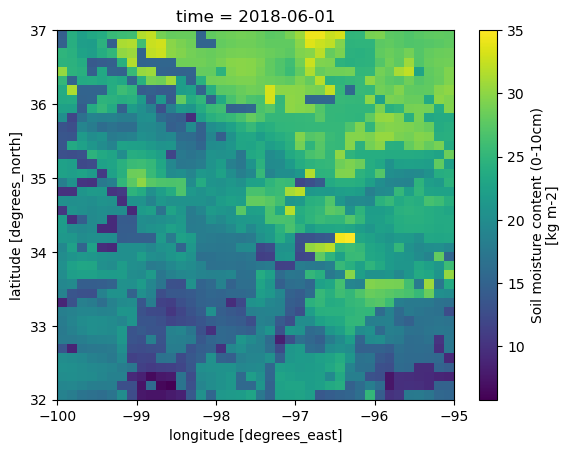

In [19]:
# Check on the subsetting via plots
nldas_sm[0,:,:].plot()

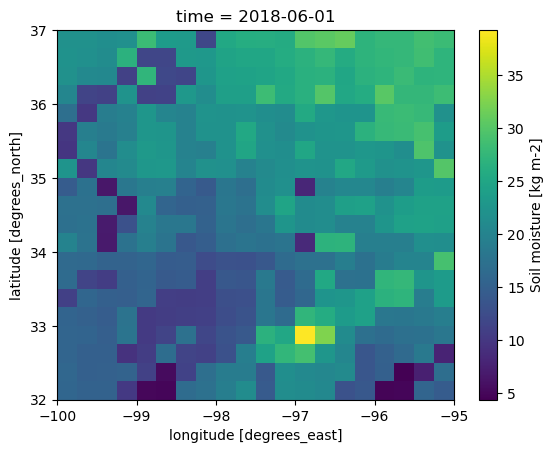

In [20]:
gldas_sm[0,:,:].plot()

### Handle CYGNSS differently

- Set coordinates to "latitude" and "longitude" (they're listed as 2D variables in the file)
- Clip to bounding box
- Subset by variable (soil moisture)

In [39]:
# Reassign coordinates using the latitude and longitude variables
cygnss_ass = cygnss_ds.set_coords(("latitude", "longitude"))
#cygnss_ass

# Clip the soil moisture variable to the specified bounding box for Southern Great Plains
cygnss_sgp_sm = cygnss_ass.SM_daily.where((cygnss_ass.latitude > min_lat) & (cygnss_ass.latitude < max_lat) & (cygnss_ass.longitude > min_lon) & (cygnss_ass.longitude < max_lon))
#cygnss_sgp_sm

# Check on the clipped reassigned coordinates
cygnss_sgp_sm[0,:,:].plot(x="longitude", y="latitude",xlim=(min_lon,max_lon),ylim=(min_lat,max_lat))

<xarray.Dataset>
Dimensions:         (time: 1, lat: 252, lon: 802, startstop: 2, timeslices: 4)
Coordinates:
  * time            (time) datetime64[ns] 2018-06-01T12:00:00
    latitude        (lat, lon) float32 dask.array<chunksize=(252, 802), meta=np.ndarray>
    longitude       (lat, lon) float32 dask.array<chunksize=(252, 802), meta=np.ndarray>
Dimensions without coordinates: lat, lon, startstop, timeslices
Data variables:
    timeintervals   (startstop, timeslices) timedelta64[ns] dask.array<chunksize=(2, 4), meta=np.ndarray>
    SIGMA_daily     (time, lat, lon) float32 dask.array<chunksize=(1, 252, 802), meta=np.ndarray>
    SM_daily        (time, lat, lon) float32 dask.array<chunksize=(1, 252, 802), meta=np.ndarray>
    SM_subdaily     (timeslices, lat, lon) float32 dask.array<chunksize=(4, 252, 802), meta=np.ndarray>
    SIGMA_subdaily  (timeslices, lat, lon) float32 dask.array<chunksize=(4, 252, 802), meta=np.ndarray>
Attributes: (12/40)
    source:                  ucar_cu_cygnss_sm_v1_2018_152.nc
    id:                      PODAAC-CYGNU-L3SM1
    ShortName:               CYGNSS_L3_SOIL_MOISTURE_V1.0
    title:                   CYGNSS Level 3 Soil Moisture from UCAR/CU
    summary:                 The CYGNSS Level 3 Soil Moisture Product provide...
    comment:                 Dataset created by UCAR and CU Boulder
    ...                      ...
    time_coverage_start:     2018-06-01T00:00:00
    time_coverage_end:       2018-06-01T23:59:59
    time_coverage_duration:  P1D
    date_created:            2019-04-24T00:00:00
    date_modified:           2020-11-03T01:02:55
    date_issued:             2020-11-03T01:02:55

In [73]:
import numpy as np

cygnss_sub = np.where(np.logical_and(np.logical_and(cygnss_ass.latitude>min_lat,cygnss_ass.latitude<max_lat),np.logical_and(cygnss_ass.longitude>min_lon,cygnss_ass.longitude<max_lon)))
#cygnss_ass.latitude.values

array([[-38.14157 , -38.14157 , -38.14157 , ..., -38.14157 , -38.14157 ,
        -38.14157 ],
       [-37.785137, -37.785137, -37.785137, ..., -37.785137, -37.785137,
        -37.785137],
       [-37.430386, -37.430386, -37.430386, ..., -37.430386, -37.430386,
        -37.430386],
       ...,
       [ 37.430386,  37.430386,  37.430386, ...,  37.430386,  37.430386,
         37.430386],
       [ 37.785137,  37.785137,  37.785137, ...,  37.785137,  37.785137,
         37.785137],
       [ 38.14157 ,  38.14157 ,  38.14157 , ...,  38.14157 ,  38.14157 ,
         38.14157 ]], dtype=float32)

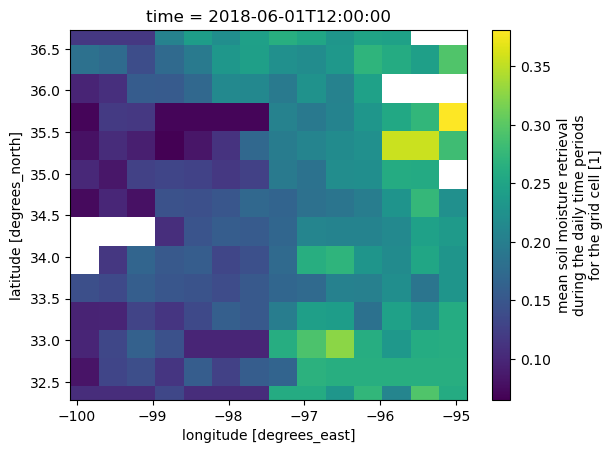

In [77]:
cygnss_ass.latitude[cygnss_sub]
cygnss_ass.longitude[cygnss_sub]
#cygnss_sub

#cygnss_ass.SM_daily[0,:,:][cygnss_sub]

# Check on the clipped reassigned coordinates
#cygnss_sgp_sm[0,:,:].plot(x="longitude", y="latitude",xlim=(min_lon,max_lon),ylim=(min_lat,max_lat))
cygnss_ass.SM_daily[0,:,:][cygnss_sub].plot(x="longitude", y="latitude")
#cygnss_ass.SM_daily[0,:,:][cygnss_sub]

### Changes this to interp function (bring LDAS to CYGNSS)

PLot LDAS again to show what it looks like 

Create mask for undefined points from CYGNSS and apply to LDAS

### Re-grid to same spatial resolution

Interpolate GLDAS and CYGNSS to NLDAS grid resolution (0.125 deg x 0.125 deg)

In [115]:
# NLDAS --> CYGNSS interpolation
nx, ny = np.meshgrid(nldas_sm.lon.values, nldas_sm.lat.values)
nldas_pts = np.stack([nx.ravel(), ny.ravel()], axis=1)

#cx, cy, = cygnss_ass.longitude[cygnss_sub]
cx, cy = cygnss_sgp_sm.longitude.values, cygnss_sgp_sm.latitude.values
cygnss_pts = np.stack([cx.ravel(), cy.ravel()], axis=1)

#grid = griddata(nldas_pts, nldas_sm.values, cygnss_pts, method='nearest')
nldas_sm[0,:,:].values
#nx.shape, ny.shape, nldas_pts.shape, cx.shape, cy.shape, cygnss_pts.shape

#grid = griddata(cygnss_pts)


array([[18.63    , 18.08    , 17.05    , ..., 17.19    , 15.589999,
        15.349999],
       [19.189999, 19.289999, 18.85    , ...,  9.309999, 14.94    ,
        14.99    ],
       [20.039999, 20.09    , 19.93    , ...,  9.21    ,  8.849999,
         8.63    ],
       ...,
       [24.75    , 24.38    , 22.57    , ..., 27.949999, 28.34    ,
        28.48    ],
       [14.7     , 24.15    , 22.05    , ..., 27.32    , 27.539999,
        27.859999],
       [14.57    , 24.06    , 22.23    , ..., 27.75    , 27.84    ,
        27.73    ]], dtype=float32)

In [118]:
cx, cy = cygnss_ass.longitude.values[cygnss_sub], cygnss_ass.latitude.values[cygnss_sub]
cygnss_pts = np.stack([cx.ravel(), cy.ravel()], axis=1)

cx.shape, cy.shape, cygnss_pts.shape

#cygnss_ass.longitude.values[cygnss_sub].shape
#grid = griddata(cygnss_pts, cygnss_ass.SM_daily[0,:,:][cygnss_sub].shape, nldas_pts, method='nearest')
nldas_pts.shape, nldas_sm[0,:,:].values.shape, cygnss_pts.shape
#grid = griddata(nldas_pts, nldas_sm.values, cygnss_pts, method='nearest')

((1600, 2), (40, 40), (196, 2))

In [108]:

def func(x, y):
    return x*(1-x)*np.cos(4*np.pi*x) * np.sin(4*np.pi*y**2)**2

grid_x, grid_y = np.mgrid[0:1:100j, 0:1:200j]

grid_x.shape #(100,200)
grid_y.shape #(100,200)
(grid_x, grid_y)

rng = np.random.default_rng()
points = rng.random((1000, 2)) #(1000,2)
values = func(points[:,0], points[:,1]) #(1000,)

grid_x.shape, grid_y.shape, points.shape, values.shape, grid_z0.shape

grid_z0 = griddata(points, values, (grid_x, grid_y), method='nearest')
#grid_z0.shape (100,200))

grid_x.shape, grid_y.shape, points.shape, values.shape, grid_z0.shape
# #Geogrid lat/lon points
#     geog = xr.open_dataset('F:/geo_em.d01.nc')
    
#     gex, gey = geog.CLONG.values[0,:,:], geog.CLAT.values[0,:,:]
#     geog_pts = np.stack([gex.ravel(), gey.ravel()], axis=1)
    
#     #Gridrad lat/lon points
    
#     grx, gry = np.meshgrid(ds.lons.values, ds.lats.values)
#     grx[grx>180] -= 360
#     gr_pts = np.stack([grx.ravel(), gry.ravel()], axis=1)
    
#     #REFC_MAX points
#     ref_pts = ds.REFC_MAX.values
    
#     ref_pts[0,:,0] = 0
#     ref_pts[0,:,-1] = 0
#     ref_pts[0,0,:] = 0
#     ref_pts[0,-1,:] = 0
 
#     interp = griddata(gr_pts, ref_pts.flatten(), geog_pts, method='nearest', fill_value=0)
    
#     interp = np.reshape(interp, (1, 899, 1399))


# GLDAS --> NLDAS interpolation

((100, 200), (100, 200), (1000, 2), (1000,), (100, 200))

### Match temporal resolution

Resample NLDAS and GLDAS to daily time resolution to match CYGNSS.

In [106]:
nldas_sm_daily = nldas_sm.resample(time="1D").mean()
gldas_sm_daily = gldas_sm.resample(time="1D").mean()
#gldas_sm
#nldas_sm_daily.plot()
#gldas_sm_daily.plot()

### Ensure same units

Divide NLDAS and GLDAS by 100.0 to convert from [kg m-2] to [m^3 m-3].


CYGNSS is in [cm^3 cm-3], which is identical to [m^3 m-3].


In [107]:
nldas_sm_daily = nldas_sm_daily/100.0
gldas_sm_daily = gldas_sm_daily/100.0

## Derive area-averages

## Plot differences